## VAE analysis of two lung cancer sets

Here we training a VAE of two different datasets within the TCGA. We will first merge the two datasets and subsequently try to separate the samples based on their latent variables. This is made in analogue with the notebook on PCA.

First we retrieve our two TCGA lungcancer data from cbioportal.org. One of the sets are from [Lung Adenocarcinomas](https://en.wikipedia.org/wiki/Adenocarcinoma_of_the_lung) and the other is from [Lung Squamous Cell Carcinomas](https://en.wikipedia.org/wiki/Squamous-cell_carcinoma_of_the_lung). The code for the retrieval of this data set is not important for the understanding of the analysis, but can be found in the module tcga_read. Execute the code and proceed to next step.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import sys
sys.path.append("..") # Read loacal modules for tcga access and qvalue calculations
import tcga_read as tcga

luad = tcga.get_expression_data("../../data/luad.tsv.gz", 'http://download.cbioportal.org/luad_tcga_pan_can_atlas_2018.tar.gz',"data_RNA_Seq_v2_expression_median.txt")
lusc = tcga.get_expression_data("../../data/lusc.tsv.gz", 'http://download.cbioportal.org/lusc_tcga_pan_can_atlas_2018.tar.gz',"data_RNA_Seq_v2_expression_median.txt")

We now merge the datasets, and see too that we only include transcripts that are measured in all the carcinomas with an count larger than 0. Further we scale the measurements so that every gene expression value is scaled between 0 and 1, using sk-learns [MinMaxScaler()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html).

In [2]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
combined = pd.concat([lusc, luad], axis=1, sort=False)
combined.dropna(axis=0, how='any', inplace=True)
combined = combined.loc[~(combined<=0.0).any(axis=1)]
X=scaler.fit_transform(np.log2(combined).T).T
combined = pd.DataFrame(data=X,index=combined.index,columns=combined.columns)

We are setting up an istance of a machine learning framework, [PyTorch](https://en.wikipedia.org/wiki/PyTorch). It will help us fitting the needed neural network.

In [3]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torch.utils.data
from torch.nn import functional as F
from torchvision import datasets, transforms


import numpy as np

from tqdm import tqdm
from torchvision.utils import make_grid

## We use a GPU and hence need cuda, https://en.wikipedia.org/wiki/CUDA
no_cuda = False

## Some arbitrarly selected training parameters
batch_size, lr, epochs, log_interval = 128, 1e-3, 1000, 10

## Some parameters governing the architecture.
hidden_dim, latent_dim = 64, 2

use_cuda = not no_cuda and torch.cuda.is_available()

torch.manual_seed(4711)

if use_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}


When training a network on a GPU, we need a special data öoader that can transfer the data to the GPU.

In [4]:
class ExpressionDataset(Dataset):
    def __init__(self, datapoints, labels):
        self.x_dim = datapoints.shape[0]
        self.datapoints = torch.tensor(datapoints.to_numpy().T, dtype=torch.float32)
        print(self.datapoints)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.datapoints[idx],self.labels[idx]

train_dataset = ExpressionDataset(combined,([1.0 for _ in lusc.columns]+[ 0.0 for _ in luad.columns]))
#train_dataset = ExpressionDataset(combined,(["LUSC" for _ in lusc.columns]+["LUAD" for _ in luad.columns]))
#test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False, **kwargs)
x_dim  = train_dataset.x_dim

tensor([[0.7966, 0.7539, 0.5268,  ..., 0.4000, 0.1724, 0.3890],
        [0.4545, 0.6363, 0.5624,  ..., 0.6170, 0.5138, 0.4735],
        [0.0000, 0.7093, 0.6046,  ..., 0.0454, 0.4523, 0.3972],
        ...,
        [0.6600, 0.5818, 0.4055,  ..., 0.4112, 0.7615, 0.2131],
        [0.6401, 0.1870, 0.6983,  ..., 0.6335, 0.7845, 0.2495],
        [0.5654, 0.6486, 0.8129,  ..., 0.6818, 0.7986, 0.2701]])


Now we design the VAE. We use an architecure where 13046 features are first throtteled down to 64 features (fc1) then to 2 features, which we predict both mean and variance for (fc21 and fc22).   

We reparametrize those 2 variables, and then expand them to 64 (fc3) and 13046 (fc4) features.

In [5]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(x_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)
        self.fc22 = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, x_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        out = torch.sigmoid(self.fc4(h3))
        return out

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, x_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


Next, we next select a gradient descent optimizer, [Adam](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam), and select a fuction to optimize, the loss_function, and we define a train and test procedure to use.

In [6]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)


# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, x_dim), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    #print(f"BCE={BCE}, KLD={KLD}")
    return BCE + KLD


def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if epoch % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))
    if epoch % log_interval == 0:
        print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
#        for i, (data, _) in enumerate(train_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
    if epoch % log_interval == 0:
        test_loss /= len(test_loader.dataset)
        print('====> Test set loss: {:.4f}'.format(test_loss))


Now we are set to run the procedure for 1000 epochs.

In [7]:
for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)

Train Epoch: 10 [0/994 (0%)]	Loss: 8792.989258
Train Epoch: 10 [128/994 (12%)]	Loss: 8802.832031
Train Epoch: 10 [256/994 (25%)]	Loss: 8801.497070
Train Epoch: 10 [384/994 (38%)]	Loss: 8806.785156
Train Epoch: 10 [512/994 (50%)]	Loss: 8798.025391
Train Epoch: 10 [640/994 (62%)]	Loss: 8803.156250
Train Epoch: 10 [768/994 (75%)]	Loss: 8792.065430
Train Epoch: 10 [686/994 (88%)]	Loss: 8811.276148
====> Epoch: 10 Average loss: 8800.7706
====> Test set loss: 8797.6908
Train Epoch: 20 [0/994 (0%)]	Loss: 8738.829102
Train Epoch: 20 [128/994 (12%)]	Loss: 8732.951172
Train Epoch: 20 [256/994 (25%)]	Loss: 8746.095703
Train Epoch: 20 [384/994 (38%)]	Loss: 8754.061523
Train Epoch: 20 [512/994 (50%)]	Loss: 8742.980469
Train Epoch: 20 [640/994 (62%)]	Loss: 8748.702148
Train Epoch: 20 [768/994 (75%)]	Loss: 8730.905273
Train Epoch: 20 [686/994 (88%)]	Loss: 8758.124362
====> Epoch: 20 Average loss: 8743.6574
====> Test set loss: 8740.4844
Train Epoch: 30 [0/994 (0%)]	Loss: 8709.035156
Train Epoch: 30 [

====> Test set loss: 8676.6530
Train Epoch: 190 [0/994 (0%)]	Loss: 8675.082031
Train Epoch: 190 [128/994 (12%)]	Loss: 8680.291992
Train Epoch: 190 [256/994 (25%)]	Loss: 8691.002930
Train Epoch: 190 [384/994 (38%)]	Loss: 8667.251953
Train Epoch: 190 [512/994 (50%)]	Loss: 8683.860352
Train Epoch: 190 [640/994 (62%)]	Loss: 8684.139648
Train Epoch: 190 [768/994 (75%)]	Loss: 8681.730469
Train Epoch: 190 [686/994 (88%)]	Loss: 8643.454082
====> Epoch: 190 Average loss: 8676.8295
====> Test set loss: 8676.1793
Train Epoch: 200 [0/994 (0%)]	Loss: 8681.663086
Train Epoch: 200 [128/994 (12%)]	Loss: 8668.091797
Train Epoch: 200 [256/994 (25%)]	Loss: 8673.872070
Train Epoch: 200 [384/994 (38%)]	Loss: 8677.295898
Train Epoch: 200 [512/994 (50%)]	Loss: 8683.222656
Train Epoch: 200 [640/994 (62%)]	Loss: 8665.553711
Train Epoch: 200 [768/994 (75%)]	Loss: 8672.204102
Train Epoch: 200 [686/994 (88%)]	Loss: 8689.522959
====> Epoch: 200 Average loss: 8676.0331
====> Test set loss: 8675.7525
Train Epoch: 21

====> Test set loss: 8667.7780
Train Epoch: 370 [0/994 (0%)]	Loss: 8677.730469
Train Epoch: 370 [128/994 (12%)]	Loss: 8685.972656
Train Epoch: 370 [256/994 (25%)]	Loss: 8678.284180
Train Epoch: 370 [384/994 (38%)]	Loss: 8674.279297
Train Epoch: 370 [512/994 (50%)]	Loss: 8671.650391
Train Epoch: 370 [640/994 (62%)]	Loss: 8663.050781
Train Epoch: 370 [768/994 (75%)]	Loss: 8654.585938
Train Epoch: 370 [686/994 (88%)]	Loss: 8658.141582
====> Epoch: 370 Average loss: 8670.8338
====> Test set loss: 8669.9780
Train Epoch: 380 [0/994 (0%)]	Loss: 8662.584961
Train Epoch: 380 [128/994 (12%)]	Loss: 8680.928711
Train Epoch: 380 [256/994 (25%)]	Loss: 8679.944336
Train Epoch: 380 [384/994 (38%)]	Loss: 8668.985352
Train Epoch: 380 [512/994 (50%)]	Loss: 8659.825195
Train Epoch: 380 [640/994 (62%)]	Loss: 8663.745117
Train Epoch: 380 [768/994 (75%)]	Loss: 8665.621094
Train Epoch: 380 [686/994 (88%)]	Loss: 8659.862883
====> Epoch: 380 Average loss: 8667.9234
====> Test set loss: 8666.7232
Train Epoch: 39

====> Test set loss: 8668.8804
Train Epoch: 550 [0/994 (0%)]	Loss: 8648.820312
Train Epoch: 550 [128/994 (12%)]	Loss: 8657.298828
Train Epoch: 550 [256/994 (25%)]	Loss: 8669.317383
Train Epoch: 550 [384/994 (38%)]	Loss: 8649.674805
Train Epoch: 550 [512/994 (50%)]	Loss: 8686.325195
Train Epoch: 550 [640/994 (62%)]	Loss: 8660.325195
Train Epoch: 550 [768/994 (75%)]	Loss: 8671.465820
Train Epoch: 550 [686/994 (88%)]	Loss: 8647.066327
====> Epoch: 550 Average loss: 8661.7159
====> Test set loss: 8659.7987
Train Epoch: 560 [0/994 (0%)]	Loss: 8660.707031
Train Epoch: 560 [128/994 (12%)]	Loss: 8668.515625
Train Epoch: 560 [256/994 (25%)]	Loss: 8657.032227
Train Epoch: 560 [384/994 (38%)]	Loss: 8660.536133
Train Epoch: 560 [512/994 (50%)]	Loss: 8650.877930
Train Epoch: 560 [640/994 (62%)]	Loss: 8665.796875
Train Epoch: 560 [768/994 (75%)]	Loss: 8656.810547
Train Epoch: 560 [686/994 (88%)]	Loss: 8677.107143
====> Epoch: 560 Average loss: 8661.7222
====> Test set loss: 8663.0833
Train Epoch: 57

====> Test set loss: 8654.5846
Train Epoch: 730 [0/994 (0%)]	Loss: 8646.878906
Train Epoch: 730 [128/994 (12%)]	Loss: 8664.060547
Train Epoch: 730 [256/994 (25%)]	Loss: 8658.542969
Train Epoch: 730 [384/994 (38%)]	Loss: 8651.935547
Train Epoch: 730 [512/994 (50%)]	Loss: 8655.420898
Train Epoch: 730 [640/994 (62%)]	Loss: 8658.356445
Train Epoch: 730 [768/994 (75%)]	Loss: 8655.960938
Train Epoch: 730 [686/994 (88%)]	Loss: 8655.433036
====> Epoch: 730 Average loss: 8655.8355
====> Test set loss: 8655.5553
Train Epoch: 740 [0/994 (0%)]	Loss: 8659.518555
Train Epoch: 740 [128/994 (12%)]	Loss: 8645.993164
Train Epoch: 740 [256/994 (25%)]	Loss: 8641.267578
Train Epoch: 740 [384/994 (38%)]	Loss: 8641.820312
Train Epoch: 740 [512/994 (50%)]	Loss: 8659.485352
Train Epoch: 740 [640/994 (62%)]	Loss: 8677.287109
Train Epoch: 740 [768/994 (75%)]	Loss: 8662.480469
Train Epoch: 740 [686/994 (88%)]	Loss: 8653.311224
====> Epoch: 740 Average loss: 8655.2008
====> Test set loss: 8654.6736
Train Epoch: 75

====> Test set loss: 8650.7385
Train Epoch: 910 [0/994 (0%)]	Loss: 8645.694336
Train Epoch: 910 [128/994 (12%)]	Loss: 8648.983398
Train Epoch: 910 [256/994 (25%)]	Loss: 8642.826172
Train Epoch: 910 [384/994 (38%)]	Loss: 8649.105469
Train Epoch: 910 [512/994 (50%)]	Loss: 8657.480469
Train Epoch: 910 [640/994 (62%)]	Loss: 8648.833984
Train Epoch: 910 [768/994 (75%)]	Loss: 8669.442383
Train Epoch: 910 [686/994 (88%)]	Loss: 8654.973852
====> Epoch: 910 Average loss: 8652.0828
====> Test set loss: 8650.2860
Train Epoch: 920 [0/994 (0%)]	Loss: 8652.788086
Train Epoch: 920 [128/994 (12%)]	Loss: 8649.651367
Train Epoch: 920 [256/994 (25%)]	Loss: 8630.443359
Train Epoch: 920 [384/994 (38%)]	Loss: 8645.681641
Train Epoch: 920 [512/994 (50%)]	Loss: 8661.604492
Train Epoch: 920 [640/994 (62%)]	Loss: 8657.315430
Train Epoch: 920 [768/994 (75%)]	Loss: 8658.258789
Train Epoch: 920 [686/994 (88%)]	Loss: 8648.443240
====> Epoch: 920 Average loss: 8650.5861
====> Test set loss: 8649.8946
Train Epoch: 93

We have now trained our VAE. We can first evaluate it for the datapoints we trained it on, and get their embeddings in a vector, $y$.

In [8]:
model.eval()

x_batch, z_batch = [], []
with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.to(device)
        
        x_hat_, mean_, log_var = model(x)
        x_batch.append(x_hat_.cpu().detach().numpy())
        z_batch.append(mean_.cpu().detach().numpy())

x_hat = np.concatenate(x_batch, axis=0)
z = np.concatenate(z_batch, axis=0)

100%|██████████| 8/8 [00:00<00:00, 100.20it/s]


We can now use the embeddings to describe our data. Much like for the PCA we can use the embeddings to give a dimentionallity reduced description of each cancer's expression profile. 

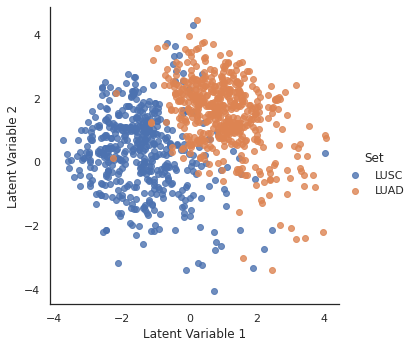

In [9]:
transformed_patients = pd.DataFrame(data=z,columns=["Latent Variable 1","Latent Variable 2"],index=list(lusc.columns) + list(luad.columns))
transformed_patients["Set"]= (["LUSC" for _ in lusc.columns]+["LUAD" for _ in luad.columns])

sns.set(rc={'figure.figsize':(10,10)})
sns.set_style("white")
#sns.set_context("talk")

sns.lmplot(x="Latent Variable 1",y="Latent Variable 2", hue='Set', data=transformed_patients, fit_reg=False)

Here we see a non-complet separation of the patients based on two latent variables.

Furter, we can use the network to generate "typical" expression profiles. The LUSC samples had embedings centering around [-2,0] and LUAD around [1,2]. We can generate two such profiles. 

In [10]:
z_fix = torch.tensor([[-2.,0.],[1.,2.]])

z_fix = z_fix.to(device)
x_fix = model.decode(z_fix).cpu().detach().numpy()
predicted = pd.DataFrame(data=x_fix.T, index=combined.index, columns=["LUSC", "LUAD"])

We can now identify the genes most differential between the typical LUSC and LUAD sample. 

In [11]:
predicted["diff"] = predicted["LUSC"] - predicted["LUAD"]
# predicted.sort_values(by='diff', ascending=False, inplace = True)

The genes pointing in a negative direction for the two components are:

In [12]:
predicted["diff"].idxmin(axis=0)

'ACSL5'

In [13]:
predicted["diff"].idxmax(axis=0)

'S1PR5'

Here the genes ACSL5 and S1PR5 seems to be the largest differentiators beteen th egenes in LUSC and LUAD. We can also note that as before, the Gene KRT17 seems quite different between the cancer types:

In [14]:
predicted.loc["KRT17"]

LUSC    0.765213
LUAD    0.442689
diff    0.322525
Name: KRT17, dtype: float32